In [17]:
import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.initializers import Constant
from tensorflow.keras.metrics import BinaryAccuracy,Precision,Recall,AUC
from tensorflow.keras.losses import BinaryCrossentropy,BinaryFocalCrossentropy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard

In [31]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
df = pd.read_csv('creditcard.csv')

In [3]:
df2 = df.copy().drop(['Time'],axis=1)
df2['amount_log'] = np.log(df2['Amount']+1)
df3 = df2.copy().drop(['Amount'],axis=1)
df3

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,amount_log
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,5.014760
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,1.305626
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,5.939276
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,4.824306
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,4.262539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0,0.570980
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0,3.249987
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0,4.232366
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0,2.397895


In [4]:
train_df, val_df = train_test_split(df3, test_size=0.2)

target = ['Class']

y_train = train_df[target].to_numpy()
x_train = train_df.copy().drop(target,axis=1).to_numpy()

y_val = val_df[target].to_numpy()
x_val = val_df.copy().drop(target,axis=1).to_numpy()

In [5]:
print("Train Records: {} Positive Labels: {} Percent : {:.4%}".format(len(y_train),np.count_nonzero(y_train),np.count_nonzero(y_train)/len(y_train)))
print("Val Records: {} Positive Labels: {} Percent : {:.4%}".format(len(y_val),np.count_nonzero(y_val),np.count_nonzero(y_val)/len(y_val)))

Train Records: 227845 Positive Labels: 395 Percent : 0.1734%
Val Records: 56962 Positive Labels: 97 Percent : 0.1703%


In [14]:
def bias_builder(arr):
    return np.log(np.count_nonzero(arr)/len(arr))

def build_model():
    input_layer = Input(shape=(x_train.shape[-1],), name="input_layer")

    last_layer = Dense(units=16,activation='relu',name="last_dense")(input_layer)
    last_dropout = Dropout(.5)(last_layer)

    binary_output = Dense(units=1,activation='sigmoid',name='binary_output',bias_initializer=Constant(bias_builder(y_train)))(last_layer)

    model = Model(inputs=input_layer,outputs=binary_output,name="binary_model")

    return model

In [25]:
model = build_model()

In [26]:
model.summary()

Model: "binary_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 29)]              0         
                                                                 
 last_dense (Dense)          (None, 16)                480       
                                                                 
 binary_output (Dense)       (None, 1)                 17        
                                                                 
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(optimizer=SGD(learning_rate=.01),loss=BinaryCrossentropy(),metrics=[BinaryAccuracy(name='accuracy'),Precision(name='precision'),Recall(name='recall'),AUC(name='auc'),AUC(name='prc', curve='PR')])

early_stopping = EarlyStopping(monitor='val_loss',verbose=1,patience=10,mode='max',restore_best_weights=True)

In [28]:
binary_history = model.fit(x_train,y_train,batch_size=2048,epochs=100,validation_data=(x_val, y_val))

Epoch 1/100
112/112 [==============================] - 3s 11ms/step - loss: 0.0107 - accuracy: 0.9983 - precision: 1.0000 - recall: 0.0025 - auc: 0.6706 - prc: 0.2534 - val_loss: 0.0103 - val_accuracy: 0.9983 - val_precision: 1.0000 - val_recall: 0.0103 - val_auc: 0.6955 - val_prc: 0.2564
Epoch 2/100
112/112 [==============================] - 0s 4ms/step - loss: 0.0094 - accuracy: 0.9983 - precision: 1.0000 - recall: 0.0278 - auc: 0.7592 - prc: 0.4062 - val_loss: 0.0091 - val_accuracy: 0.9984 - val_precision: 1.0000 - val_recall: 0.0619 - val_auc: 0.7883 - val_prc: 0.4241
Epoch 3/100
112/112 [==============================] - 1s 5ms/step - loss: 0.0084 - accuracy: 0.9984 - precision: 0.9211 - recall: 0.0886 - auc: 0.8110 - prc: 0.4945 - val_loss: 0.0082 - val_accuracy: 0.9984 - val_precision: 0.8182 - val_recall: 0.0928 - val_auc: 0.8192 - val_prc: 0.5045
Epoch 4/100
112/112 [==============================] - 0s 4ms/step - loss: 0.0077 - accuracy: 0.9985 - precision: 0.8358 - recall: 0

In [32]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

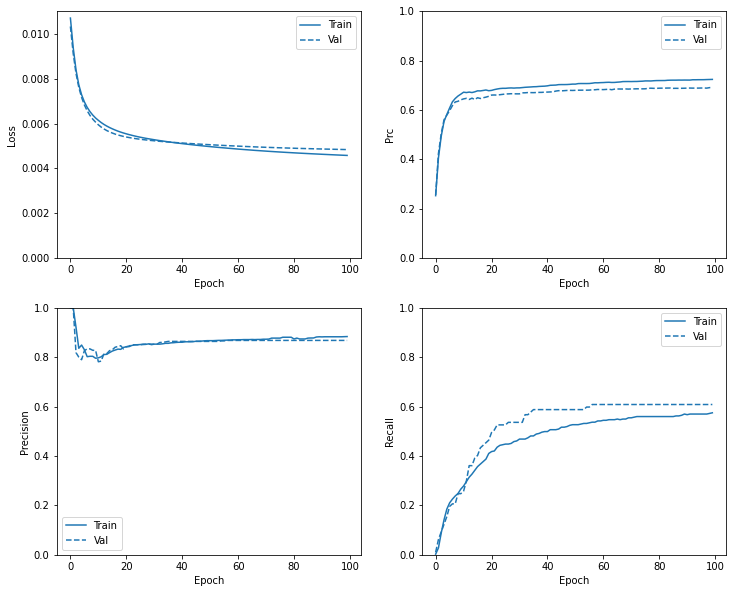

In [33]:
plot_metrics(binary_history)

In [36]:
target

['amount_log', 'Class']

In [37]:
target = ['amount_log']
removes = ['amount_log','Class']

y_train2 = train_df[target].to_numpy()
x_train2 = train_df.copy().drop(removes,axis=1).to_numpy()

y_val2 = val_df[target].to_numpy()
x_val2 = val_df.copy().drop(removes,axis=1).to_numpy()

In [ ]:
y_train2